# Лабораторная 3. Сверточная нейронная сеть

Задача - написать сверточную нейронную сеть для классификации набора данных MNIST (http://yann.lecun.com/exdb/mnist/). Файлы в формате idx не очень удобны, поэтому скачаем датасет с сайта https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz. Яном ЛеКаном была достигнута ошибка без предобучения и предобработки на его LeNet-5 на уровне 0.95%. Попробуем повторить.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
# import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

Скачаем датасет и посмотрим на его размеры. У нас 60 тысяч примеров в обучающей выборке и 10 тысяч в тестовой. Размер изображения 28x28 пикселей.

In [4]:
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train, y_train), (x_test, y_test)

In [5]:
(x_train, y_train), (x_test, y_test) = load_data('3. mnist.npz')

indices_train = np.random.permutation(1024)
x_train = x_train[indices_train]
y_train = y_train[indices_train]

indices_train = np.random.permutation(1024)
x_test = x_test[indices_train]
y_test = y_test[indices_train]

In [6]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1024, 28, 28)
(1024,)
(1024, 28, 28)
(1024,)


In [7]:
unique, counts = np.unique(y_train, return_counts=True)
df = pd.DataFrame(counts, columns=["Counts"])
df

,Counts
0,100
1,120
2,101
3,95
4,108
5,92
6,95
7,122
8,90
9,101


# t-SNE

Визуализируем пространство нашей обучающей выборки с помощью алгоритма t-SNE, чтобы оценить разделимость классов

In [17]:
X_train = x_train.reshape(x_train.shape[0], 784)

In [18]:
embed=TSNE(n_components=2,perplexity=10,learning_rate=200, n_iter_without_progress=100)

In [19]:
X_embedded = embed.fit_transform(X_train)

KeyboardInterrupt: 

In [ ]:
print('Расхождение Кульбака-Лейблера после оптимизации: ', embed.kl_divergence_)

Расхождение Кульбака-Лейблера после оптимизации:  3.4899332523345947


In [ ]:
fig = px.scatter(None, x=X_embedded[:,0], y=X_embedded[:,1],
labels={"x": "Dimension 1","y": "Dimension 2",},
opacity=1, color=y_train.astype(str))
fig.update_layout(dict(plot_bgcolor = 'white'))
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
showline=True, linewidth=1, linecolor='black')

fig.update_layout(title_text="t-SNE")
fig.update_traces(marker=dict(size=3))

fig.show()

NameError: name 'X_embedded' is not defined

In [ ]:
fig.write_html("tsne.html")

NameError: name 'fig' is not defined

# Le-Net 5

In [ ]:
# X = np.random.randn(6000, 28, 28)

from nn.cnn import LeNet
from nn.losses.cross_entropy import CrossEntropy

arr = np.zeros((len(y_train), 10))
arr[np.arange(len(y_train)), y_train] = 1
labels_train = arr

arr = np.zeros((len(y_test), 10))
arr[np.arange(len(y_test)), y_test] = 1
labels_test = arr


model = LeNet(num_classes=10)

loss_fn = CrossEntropy()

print("Training LeNet with CrossEntropy loss...")
history = model.train(
    x_train[:, np.newaxis][:1024], labels_train[:1024],
    x_test[:, np.newaxis][:1024], labels_test[:1024],
    epochs=10,
    batch_size=32,
    learning_rate=0.0001,
    loss_fn=loss_fn,
    verbose=True
)

print("Training completed!")
print(f"Final training loss: {history['train_loss'][-1]:.4f}")
if history['val_loss']:
    print(f"Final validation loss: {history['val_loss'][-1]:.4f}")
    print(f"Final validation accuracy: {history['val_accuracy'][-1]:.4f}")

Training LeNet with CrossEntropy loss...


 25%|██▌       | 8/32 [00:49<02:29,  6.22s/it]

[]

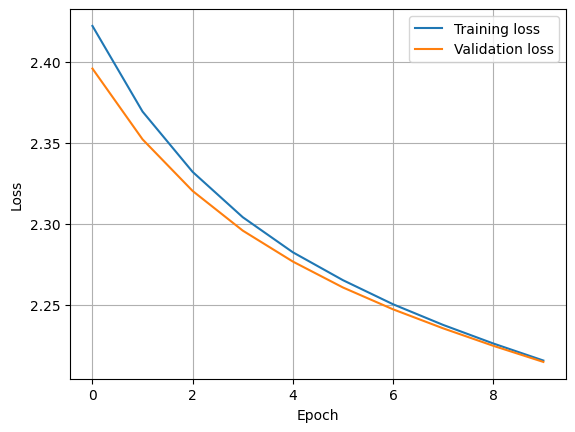

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(history["train_loss"])), history["train_loss"])
plt.plot(range(len(history["val_loss"])), history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training loss", "Validation loss"])
plt.grid()
plt.plot()

[]

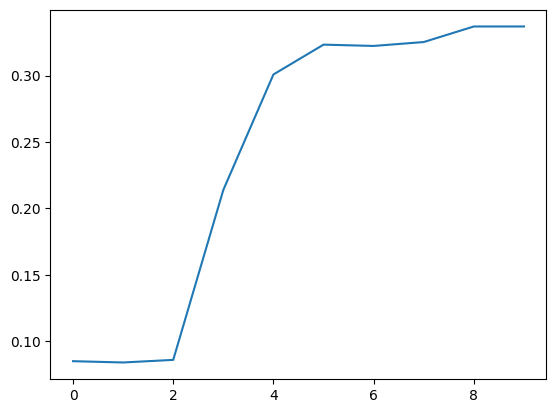

In [22]:
plt.plot(range(len(history["val_accuracy"])), history["val_accuracy"])
plt.plot()

In [23]:
from sklearn.metrics import confusion_matrix

predictions = model.forward(x_test[:, np.newaxis][:1024])

In [30]:
np.unique_counts(y_test[:1024])

UniqueCountsResult(values=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), counts=array([ 87, 130, 118, 108, 113,  89,  89, 102,  91,  97]))

<Axes: >

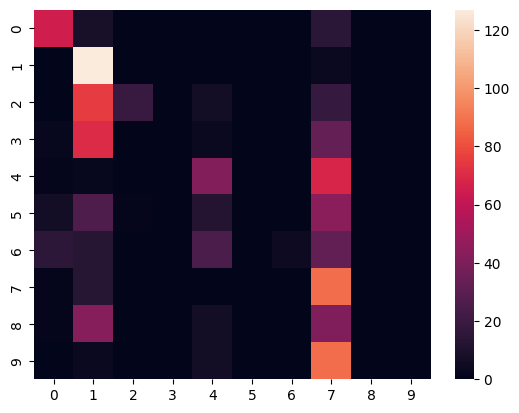

In [31]:
import seaborn as sns

y_pred = np.argmax(predictions, axis=1)

sns.heatmap(confusion_matrix(y_test[:1024], y_pred))